In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from joblib import Parallel, delayed
from multiprocessing import  Pool
from astropy.io import ascii
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
# Import
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(nb_workers=22)

INFO: Pandarallel will run on 22 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [150]:
all_stars_read = Table.read('../HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
all_stars_read.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
all_stars_read = all_stars_read.set_index('ID')

In [176]:
deltaX  = all_stars_read.x.values - all_stars_read.x.values[:,np.newaxis]
deltaY  = all_stars_read.y.values - all_stars_read.y.values[:,np.newaxis]
deltaPix = np.array(np.sqrt(deltaX**2+deltaY**2), dtype=np.float32)
# throw away mergers
deltaPix = pd.DataFrame(deltaPix, index=np.arange(1,len(deltaPix)+1,1), columns = np.arange(1,len(deltaPix)+1,1))

deltaPix[deltaPix==0] = 999
mindists = deltaPix.min(axis=1)
to_keep = mindists.index[mindists>=10]

In [177]:
all_stars = all_stars_read[(all_stars_read['ha_1']>5)&(all_stars_read['ha_1']<50)]
all_stars = all_stars[(all_stars['v_1']>5)&(all_stars['v_1']<50)]
all_stars = all_stars[(all_stars['i_1']>5)&(all_stars['i_1']<50)]
all_stars = all_stars[(all_stars['eha_2']>0)&(all_stars['eha_2']<50)]

In [178]:
red_giants = ascii.read('../HST_Guido/redgiants_coords.txt').to_pandas()
red_giants = all_stars.loc[red_giants.ID]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [179]:
pms = ascii.read('../HST_Guido/30dorallpmsstars.txt').to_pandas()
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
argmins  = np.argmin(distances, axis=1)
mindists = np.min(distances, axis=1)
argmins = argmins[mindists<1]
pms_stars = all_stars.iloc[argmins]

In [180]:
distances = np.sqrt((pms.X.values - all_stars.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars.y.values[:,np.newaxis])**2).T
distances = pd.DataFrame(distances, index=pms.index, columns = all_stars.index)
pms_id_argmins  = distances.idxmin(axis=0)#np.argmin(distances, axis=0)
mindists = distances.min(axis=0)#np.min(distances, axis=0)
#argmins = argmins[mindists<1.5
argmins = np.argmin(distances.values, axis=0)[mindists<1]
pms_id_argmins = pms_id_argmins[mindists<1]
pms = pms.iloc[argmins]
pms['AssocID'] = pms_id_argmins.index
pms = pms.set_index('AssocID').drop('NR', axis=1)
pms

,X,Y,V,eV,I,eI,Ha,eHa,LgT,eLgT,LgL,eLgL,LgHa,EW,Mass,Age,LgMdot
AssocID,,,,,,,,,,,,,,,,,
39,1515.66,778.65,11.82,0.01,11.58,0.01,10.84,0.01,3.90,0.03,4.60,0.06,1.68,-16.1,0.0,0.0,9.99
151,3799.66,4212.51,13.63,0.01,13.80,0.01,13.03,0.00,4.17,0.16,4.34,0.17,0.74,-11.9,4.9,0.5,-4.27
181,3242.22,2950.02,13.73,0.01,13.69,0.01,12.30,0.00,3.96,0.04,3.87,0.07,1.25,-43.0,0.0,0.0,9.99
202,3569.54,2491.61,13.27,0.02,13.73,0.03,11.75,0.00,4.54,3.73,5.30,3.73,1.51,-61.9,3.4,0.4,-3.62
325,3780.93,2483.78,14.25,0.00,13.86,0.00,11.25,0.00,3.86,0.03,3.64,0.07,1.77,-169.6,0.0,0.0,9.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21141,1945.35,379.54,23.80,0.06,22.54,0.03,21.32,0.17,3.66,0.02,0.03,0.06,-2.35,-46.1,1.0,3.0,-7.81
21268,2405.28,2920.34,24.33,0.07,22.97,0.02,20.59,0.14,3.64,0.02,-0.13,0.06,-1.97,-172.1,0.9,3.7,-7.43
21291,2896.09,1965.39,23.99,0.06,22.80,0.03,19.60,0.11,3.67,0.02,-0.07,0.06,-1.55,-371.2,1.0,5.1,-7.10


In [181]:
phot_df = pd.read_pickle('IRAF_output_aper3_regrid.pickle').drop('ID', axis=1).reset_index()

In [182]:
phot_df['MAG'] = phot_df['MAG'] - 0.1
phot_df.rename({'ID': 'AssocID'}, axis=1, inplace=True)

In [183]:
phot_df = phot_df[['AssocID', 'Filter', 'T_Start', 'Exp_Length', 'AREA', 'CERROR', 'CIER','FLUX', 
                   'IMAGE', 'ITIME', 'MAG', 'MERR',
                   'MSKY', 'NSKY', 'NSREJ', 'OTIME', 'RAPERT', 'XCENTER','YCENTER', 'XSHIFT', 'YSHIFT']]
phot_df = phot_df.set_index(['AssocID', 'Filter', 'T_Start']).sort_index()
len(phot_df)

1573324

In [184]:
def select_to_keep(df):
    keep = [w in to_keep for w in df.reset_index()['AssocID'].values]
    return df[keep]

In [185]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, 22)
    pool = Pool(22)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [186]:
phot_df = parallelize_dataframe(phot_df, select_to_keep)

In [187]:
phot_df = phot_df[~phot_df['MAG'].isna()]
phot_df = phot_df[~phot_df['MERR'].isna()]
phot_df = phot_df[phot_df['MAG']<30]
phot_df = phot_df[phot_df['MERR']<0.20]
len(phot_df)

571565

In [188]:
phot_df = phot_df[phot_df.groupby(['AssocID', 'Filter'])['MAG'].count() >= 3]
len(phot_df)

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


565197

In [189]:
phot_df = pd.merge(phot_df, all_stars_read[['RA', 'Dec']], left_on='AssocID', right_index=True)

565197

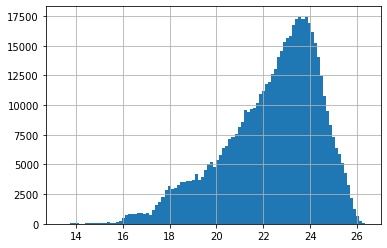

In [190]:
phot_df['MAG'].hist(bins=100)
len(phot_df)

In [191]:
def robust_mean(mags, synerrs):
    mags = mags.values
    synerrs = synerrs.values
    synerrs = synerrs[np.argsort(mags)]
    mags = np.sort(mags)
    if len(mags)>5:
        to_drop = (len(mags)//6)
        mags = mags[to_drop:-to_drop]
        synerrs = synerrs[to_drop:-to_drop]
    weighted_mean = np.nansum(1/synerrs**2 * mags) / np.nansum(1/synerrs**2)
    return weighted_mean, np.sqrt(np.mean(np.power(mags-weighted_mean,2)))


def get_mean_sigmaprime(phot_df):
    """This will take some time"""
    StarIDs = phot_df.index.get_level_values(0).unique().values
    phot_df['RobustMean'] = 0
    phot_df['RobustSigma'] = 0
    i=0
    for StarID in StarIDs:
        filters = phot_df.loc[StarID].index.get_level_values(0).unique().values
        print(filters)
        for this_filter in filters:
            sub_phot_df = phot_df.loc[StarID,this_filter]
            Lightcurve_SynErrors = sub_phot_df.MERR
            Lightcurve_mags = sub_phot_df.MAG
            TrueMag, SigmaPrime = np.median(Lightcurve_mags), np.std(Lightcurve_mags)#robust_mean(Lightcurve_mags, Lightcurve_SynErrors)
            phot_df.loc[(StarID, this_filter,),'RobustMean'] = TrueMag
            phot_df.loc[(StarID, this_filter,),'RobustSigma']= SigmaPrime
    phot_df['SigmaPrimeDeviation'] = (phot_df['MAG'] - phot_df['RobustMean']).abs() / phot_df['RobustSigma']
    phot_df['High_sigma_prime'] = phot_df['SigmaPrimeDeviation'] > 4
    return phot_df
#phot_df = get_mean_sigmaprime(phot_df)

In [192]:
def nearest_neighbours(phot_df, Nstars = 80):
    catalogue = phot_df.groupby('AssocID')['RA', 'Dec'].median()
    Nentries = len(catalogue)
    
    
    #deltaRA  = np.memmap('deltaRA.temp' , dtype='float64', mode='w+', shape=(Nentries,Nentries))
    #deltaDEC = np.memmap('deltaDec.temp', dtype='float64', mode='w+', shape=(Nentries,Nentries))
    
    deltaRA  = catalogue.RA.values - catalogue.RA.values[:,np.newaxis]
    deltaDEC = catalogue.Dec.values - catalogue.Dec.values[:,np.newaxis]
    
    deltaAngle = deltaRA**2 + deltaDEC**2
    del deltaRA, deltaDEC
    
    nearest = catalogue.index.values[np.argsort(deltaAngle, axis=1)] # To correct for ID <-> argument
    nearest = pd.DataFrame(nearest[:,1:Nstars+1], index=catalogue.index)
    return nearest

def get_local_mzp_corr(phot_df):
    phot_df['MagDiff'] = phot_df['MAG'] - phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()#['RobustMean']
    IDs = phot_df.index.get_level_values(0).unique()
    phot_df['MZPCorr']=0
    nearest = nearest_neighbours(phot_df)
    for ID in IDs:
        neightbours = nearest.loc[ID]
        neightbour_photometry = phot_df.loc[neightbours.values]
        photometry = neightbour_photometry[neightbour_photometry.MAG<23]
        if photometry.index.get_level_values(0).nunique()<20:
            photometry = neightbour_photometry
        photometry = neightbour_photometry.sort_values(by='MAG')
        MagOffset = photometry.groupby(['Filter', 'T_Start'])['MagDiff'].median()
        MagOffset = pd.DataFrame(MagOffset)
        MagOffset.columns = ['MZPCorr2']
        phot_df.loc[ID,'MZPCorr'] = pd.DataFrame(phot_df.loc[ID]).join(MagOffset)['MZPCorr2'].values
    phot_df['MAG_ORIG'] = phot_df['MAG']
    phot_df['MAG'] = phot_df['MAG'] - phot_df['MZPCorr']
    return phot_df


def distribute_work(phot_df):
    IDs = phot_df.index.get_level_values(0).unique().values
    array_splits = np.array_split(IDs, 22)
    phot_df_splits = [phot_df.loc[w] for w in array_splits]
    returns = Parallel(n_jobs=22)(delayed(get_local_mzp_corr)(i) for i in [w for w in phot_df_splits])
    return_df = returns[0]
    for sub_df in returns[1:]:
        return_df = pd.concat((return_df, sub_df))
    return return_df
phot_df = phot_df[~phot_df['MAG'].isna()]
phot_df = distribute_work(phot_df)

In [193]:
phot_df = phot_df[phot_df.MZPCorr.abs()<0.1]

In [16]:
phot_df = pd.read_pickle('cleaned_phot_df_aper4.pickle')
#phot_df.to_pickle('cleaned_phot_df_aper3.pickle')

In [4]:
phot_df = pd.read_pickle('cleaned_phot_df_aper3.pickle')

In [194]:
class Analysis():
    def __init__(self, phot_df):
        self.ApplySelection(phot_df)
        return

    def ApplySelection(self, phot_df):
        self.phot_df = phot_df#[phot_df.SynErrorDevSig<=20]
        self.phot_df = self.phot_df[self.phot_df.Exp_Length=='deep']
    
    def GetMADvalues(self):
        phot_df          = self.phot_df
        MedianMagTime    = phot_df.groupby(['AssocID', 'Filter', 'T_Start'])['MAG'].median()
        MedianMagOverall = phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()
        MagOffset        = (MedianMagTime - MedianMagOverall).abs()
        self.MAD         = MagOffset.groupby(['AssocID', 'Filter']).median()
        return self.MAD
    
    def GetMinMaxvalues(self):
        phot_df          = self.phot_df
        MaxMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].max()
        MinMagnitude     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].min()
        MinMagMagnitude  = (MaxMagnitude - MinMagnitude).abs()
        self.MinMag      = MinMagMagnitude.groupby(['AssocID', 'Filter']).median()
        return self.MinMag
    
    def GetMedMags(self):
        self.MedMag = self.phot_df.groupby(['AssocID', 'Filter'])['MAG'].median()
        return self.MedMag

    def GetMedMagErr(self):
        self.MedMagErr = self.phot_df.groupby(['AssocID', 'Filter'])['MERR'].median()
        return self.MedMagErr

    
    def GetMADPlot(self, filter_=None):
        self.GetMADvalues()
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=False, histtype='step', normed=False, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('PDF')
        plt.show()
        
        self.MAD.hist(bins=np.arange(0,1,0.002),cumulative=True, histtype='step', normed=True, linewidth=2)
        plt.xlabel('MAD Value')
        plt.ylabel('CDF')
        plt.show()
        
        self.GetMedMags()
        if filter_ !=None:
            med_mags = self.MedMag[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD[self.MAD.index.get_level_values(1)==filter_]
        else:
            med_mags = self.MedMag#[self.MedMag.index.get_level_values(1)==filter_]
            mad_vals = self.MAD#[self.MAD.index.get_level_values(1)==filter_]
        plt.hist2d(med_mags, mad_vals, bins=(np.linspace(15,28,80), np.linspace(0,0.4,50)), cmap=plt.cm.jet)
        plt.xlabel('Median magnitude')
        plt.ylabel('MAG Value')
        plt.show()
        
    
    def DrawTrumpets(self,magcol = 'MAG', IDcol = 'AssocID'):
        phot_df = self.phot_df
        merrcol = magcol.replace('MAG', 'MERR')
        # Trumpet plot
        from matplotlib.colors import LogNorm
        magnitudes = phot_df[magcol]
        filters = magnitudes.index.get_level_values(1).unique()
        plt.figure(figsize=(20,10))
        num=0
        for filter_ in np.sort(filters):
            epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
            mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
            num+=1
            plt.subplot('23'+str(num))
            xs, ys = np.array([]), np.array([])
            for i in range(len(epochs)-1):
                mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
                join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
                join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
                median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
                join_mags = join_mags.join(median_mags)
                x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
                x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
                xs = np.hstack((xs,x))
                ys = np.hstack((ys,y))
            plt.hist2d(xs, ys, bins=(np.linspace(15,28,80), np.linspace(-3,3,150)), cmap='jet', cmin=1)
            plt.title(filter_, pad=-15)
            plt.ylabel('Delta Mag')
            plt.xlabel('Median magnitude')
            plt.ylim(-1,1)
            plt.xlim(14,27)
            if num in [1,4,7]:
                plt.ylabel('Delta Mag')
            else:
                plt.yticks([])
            if num in [4,5]:
                plt.xlabel('Median magnitude')
            else:
                plt.xticks([])
            plt.ylim(-1.5,1.5)
        plt.tight_layout()
        #plt.savefig('trumpet_diagrams.png', dpi=500)
        plt.show()

    def MAG_pdf(self, magcol = 'MAG',fluxcol='FLUX_APER2', IDcol = 'AssocID'):
        phot_df = self.phot_df
        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1), histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()


        fig, ax = plt.subplots(figsize=(10,6))
        for name, group in phot_df[phot_df[fluxcol]>0].groupby('Filter')[magcol]:
            group.hist(bins=np.arange(15,30,0.1),cumulative=True, histtype='step', ax=ax, normed=True, label=name, linewidth=2)
        ax.legend()
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Normalized frequency')
        ax.set_xlim(15,30)
        plt.show()
    
    def GetNumberOfMeasurements(self):
        counts = self.phot_df['MAG'].groupby(['AssocID', 'Filter']).count()
        return counts
    
    def GetTimeSeries(self, AssocID = None, Filter=None):
        if not AssocID:
            MinMeasurements = 10
            WhichEntries    = self.GetNumberOfMeasurements()>MinMeasurements
            WhichEntries    = WhichEntries[WhichEntries]
            RandomRow       = np.random.randint(0,len(WhichEntries))
            AssocID         = WhichEntries.index.get_level_values(0)[RandomRow]
            Filter          = WhichEntries.index.get_level_values(1)[RandomRow]
        JulianDates = self.phot_df.loc[AssocID, Filter].reset_index().T_Start
        Magnitudes  = self.phot_df.loc[AssocID, Filter].MAG
        #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = self.phot_df.loc[AssocID, Filter].MERR
        
        plt.figure(figsize=(8,5))
        plt.title('AssocID ' +str(AssocID) + ' ' +Filter + ' mag ' +np.round(self.phot_df.loc[AssocID, Filter]['MAG'].median(),3).astype(str))
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none', fmt='o', ecolor='black', capthick=2)
        #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
        return JulianDates.values, Magnitudes.values, MAG_err.values
        plt.show()
        

    def median_mad_sigma(self):
        mags, mads = self.GetMedMags(), self.GetMADvalues()  
        mags = pd.DataFrame(mags)
        mags.columns = ['MAG']
        mads = pd.DataFrame(mads)
        mads.columns = ['MAD']
        # Drop first 0.5 mag and last 0.5 mag
        lower_thres = pd.DataFrame(mags.groupby('Filter').min()+0.5)#FilterMags.min()+0.5
        lower_thres.columns = ['LowerMagThresh']
        upper_thres = pd.DataFrame(mags.groupby('Filter').max()-0.5)##FilterMags.max()-0.5
        upper_thres.columns = ['UpperMagThresh']

        mags = pd.merge(mags, lower_thres, left_index=True,left_on='Filter', right_index=True)#, right_on='Filter')
        mags = pd.merge(mags, upper_thres, left_index=True,left_on='Filter', right_index=True)

        mags = mags[(mags.MAG>mags.LowerMagThresh)*(mags.MAG<mags.UpperMagThresh)]
        MagsMads = mags.copy()
        MagsMads = MagsMads.join(mads)

        MagsMads['MagBin'] = pd.cut(MagsMads['MAG'], bins=20)
        MedMadBin = pd.DataFrame(MagsMads.groupby('MagBin')['MAD'].median())
        MedMadBin.columns = ['MedMadBin']
        MagsMads = pd.merge(MagsMads,MedMadBin, left_on='MagBin', right_index=True)

        MagsMads['MADSigma'] = MagsMads['MAD'] / MagsMads['MedMadBin']
        return MagsMads
    
    def potential_candidates(self):
        MagsMads = self.median_mad_sigma()
        PotCandidates = MagsMads['MAD'].unstack()
        PotCandidates['NFilters'] = PotCandidates.count(axis=1)
        return PotCandidates
    
    def inspect(self,AssocID, Filter):
        local_phot_df = self.phot_df.loc[AssocID, Filter]
        local_phot_df = local_phot_df.sort_index()
        files = local_phot_df.IMAGE.values
        wfc = ('1' if 'wfc1' in files[0] else '2')
        files = ['./WFC'+wfc+'_crcleaned/'+w+'fits' for w in files]
        self.GetTimeSeries(AssocID, Filter)
        #racenter, deccenter = local_phot_df.ALPHA_J2000.values[0], local_phot_df.DELTA_J2000.values[0]

        racenter, deccenter = local_phot_df['RA'].median(), local_phot_df['Dec'].median()
        xs, ys = local_phot_df.XCENTER.values, local_phot_df.YCENTER.values
        apert = str(3.25*0.04/3600)
        # Make region file
        tempfile = open('temp_ds9.reg', 'w')
        print(racenter, deccenter)
        #tempfile.write("""# Region file format: DS9 version 4.1 \nglobal color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \nfk5 \n""")
        #tempfile.write('point('+str(racenter)+','+str(deccenter)+')\n')
        #tempfile.write('circle('+str(racenter)+','+str(deccenter)+','+apert+')\n')
        tempfile.write('fk5; point '+str(racenter)+' '+str(deccenter)+ '\n')
        tempfile.write('fk5; circle '+str(racenter)+' '+str(deccenter) +' ' + apert+ '\n')
        for i in range(len(xs)):
            tempfile.write('physical; point '+str(xs[i])+' '+str(ys[i])+' # color=red\n')
            print(files[i], '  ', xs[i], '  ', ys[i])
        tempfile.close()
        
        ds9_command = 'ds9 -scale zscale -lock frame wcs -lock scale '
        ds9_command += '-lock colorbar yes '
        ds9_command += ' '.join(files)
        ds9_command += ' -regions skyformat degrees -regions load all temp_ds9.reg'
        os.system(ds9_command +' &')
        #os.system('rm -rf temp_ds9.reg')
        return 
    
    def get_mad_mag_nom(self, crop = False):
        mags = self.GetMedMags()
        mads = self.GetMADvalues()
        nmeas = self.GetNumberOfMeasurements()
        magmad = pd.DataFrame(mags).join(pd.DataFrame({'MAD':mads}))
        magmadn = magmad.join(pd.DataFrame({'Nmeas':nmeas}))
        madovermedmad = self.median_mad_sigma()
        magmadnmedmad = magmadn.join(madovermedmad['MADSigma'])
        if crop:
            magmadnmedmad = magmadnmedmad[(magmadnmedmad.Nmeas>=3)&(magmadnmedmad.MAD>=0.25)&(magmadnmedmad.MAG<=30)&(magmadnmedmad.MADSigma>2)]
        return magmadnmedmad
    
    def second_brightest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[1]
        else:
            return xsort[0]
    
    def second_faintest(self,x):
        xsort=np.sort(x)
        if len(xsort)>1:
            return xsort[-2]
        else:
            return xsort[-1]
        
    def get_max_ha(self):
        phot_df = self.phot_df
        nmeas = Analyzer.GetNumberOfMeasurements()>=4
        phot_df = phot_df[phot_df.index.get_level_values(1)=='F656N']
        max_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].min()[nmeas]
        second_max_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG'].apply(lambda x: self.second_brightest(x))[nmeas]
        min_ha_mag     = phot_df.groupby(['AssocID', 'Filter'])['MAG'].max()[nmeas]
        second_min_ha  = phot_df.groupby(['AssocID', 'Filter'])['MAG'].apply(lambda x: self.second_faintest(x))[nmeas]
        ha_error_mag   = phot_df.groupby(['AssocID', 'Filter'])['MERR'].median()[nmeas]
        med_ha         = self.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N']
        maxmag_df      = pd.DataFrame({'MaxHa':max_ha_mag,'SecondMaxHa':second_max_ha,'MinHa':min_ha_mag, 'SecondMinHa':second_min_ha,'MedHa':med_ha, 'HaErr': ha_error_mag})
        return maxmag_df.droplevel(1)
    
    def get_color(self, color1, color2):
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        MedMag = self.GetMedMags()[nmeas].unstack()
        MedMagErr = self.GetMedMagErr()[nmeas].unstack()
        mag1 = MedMag[color1]
        emag1 = MedMagErr[color1]
        mag2 = MedMag[color2]
        emag2 = MedMagErr[color2]
        return mag1.dropna(), mag2.dropna(), pd.DataFrame({'Color':(mag1-mag2).dropna(), 'eColor':np.sqrt(emag1**2+emag2**2)})
    
    def merge_color_maxha(self,color1, color2):
        V, I, VI = self.get_color('F555W','F814W')
        maxha = self.get_max_ha()
        df = pd.merge(VI, maxha, right_index=True, left_index=True)
        df = pd.merge(df, V, right_index=True, left_index=True)
        df = pd.merge(df, I, right_index=True, left_index=True)
        nmeas = Analyzer.GetNumberOfMeasurements()>=3
        nmeas = (nmeas[nmeas.index.get_level_values(1)=='F656N'].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color1].droplevel(1) & nmeas[nmeas.index.get_level_values(1)==color2].droplevel(1))
        return df[nmeas]

In [195]:
Analyzer = Analysis(phot_df)

In [196]:
len(phot_df)

563216

In [197]:
a = Analyzer.GetMinMaxvalues().sort_values()#a=Analyzer.GetMinMaxvalues().sort_values(by='MAD')
a=pd.DataFrame(a).join(Analyzer.get_mad_mag_nom(), rsuffix='_mad')#

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [198]:
a=a[a.index.get_level_values(1)=='F656N']

a.sort_values(by='MAD').dropna().tail(10)

,,MAG,MAG_mad,MAD,Nmeas,MADSigma
AssocID,Filter,,,,,
4773.0,F656N,0.73700,20.591875,0.276875,8,16.908397
14252.0,F656N,0.76900,19.619000,0.277500,7,12.333333
15028.0,F656N,0.56925,17.718375,0.284625,2,11.328358
17393.0,F656N,0.83925,20.301500,0.286750,5,15.092105
10850.0,F656N,1.01250,17.595500,0.302000,3,12.019900
16976.0,F656N,0.69400,19.815000,0.309000,5,16.263158
4748.0,F656N,0.66150,20.228750,0.309250,3,16.276316
9828.0,F656N,1.39425,19.387250,0.324250,7,14.411111
13047.0,F656N,0.68200,21.236000,0.328000,3,17.150327


84.6898798 -69.0920152
./WFC1_crcleaned/ib6wd1rrq_crclean_wfc1.fits    1808.615    1069.948
./WFC1_crcleaned/ib6wd4kvq_crclean_wfc1.fits    1809.445    1113.282
./WFC1_crcleaned/ib6wd2btq_crclean_wfc1.fits    1801.184    1068.114
./WFC1_crcleaned/ib6wd3fdq_crclean_wfc1.fits    1814.694    1111.731
./WFC1_crcleaned/ib6wd5gdq_crclean_wfc1.fits    1811.633    1070.0
./WFC1_crcleaned/ib6wd7hdq_crclean_wfc1.fits    1820.0    1112.12
./WFC1_crcleaned/ib6wr8jhq_crclean_wfc1.fits    1825.022    1109.567


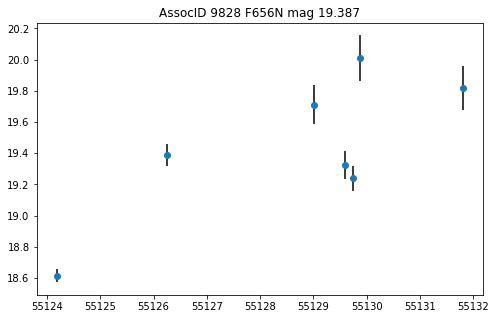

In [201]:
Analyzer.inspect(9828,'F656N')

In [66]:
medsky = phot_df.groupby(['AssocID', 'Filter'])['MSKY'].median()
skydiff = phot_df.groupby(['AssocID', 'Filter'])['MSKY'].max() - phot_df.groupby(['AssocID', 'Filter'])['MSKY'].min()
mesky_diff = pd.merge(skydiff, medsky, left_index=True, right_index=True)
mesky_diff.columns = ['Skydiff', 'MedSky']

In [67]:
sky_mad = pd.merge(a['MAD'], mesky_diff, left_index=True, right_index=True)
sky_mad['DiffoverMed'] = sky_mad.Skydiff/ sky_mad.MedSky
sky_mad = sky_mad[sky_mad.index.get_level_values(1)=='F656N']

In [68]:
ACS_variations = pd.read_pickle('../ACS/drz/phot_files/ACS_variations.pickle')

In [69]:
ACS_variations.sort_values(by='MaxminMin_sigma')

,MaxminMin,MERR,MaxminMin_sigma
ID,,,
13888,0.000,0.2130,0.000000
1475,0.000,0.0055,0.000000
1418,0.000,0.0090,0.000000
8399,0.000,0.0930,0.000000
2383,0.000,0.0515,0.000000
...,...,...,...
5217,0.508,0.0160,31.750000
10298,1.872,0.0555,33.729730
2210,0.364,0.0105,34.666667


In [70]:
len(ACS_variations[(ACS_variations.MaxminMin>=0.5)])#&(ACS_variations.MaxminMin_sigma>=3)])

69

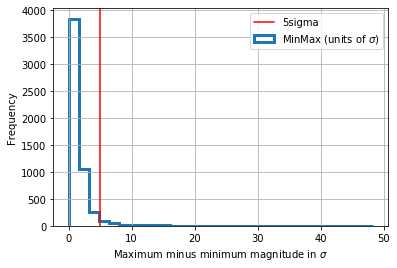

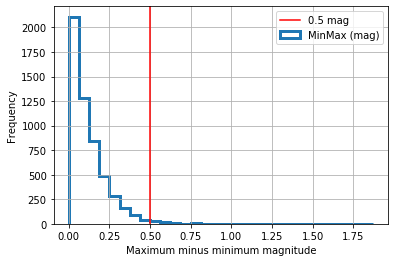

In [71]:
ACS_variations.MaxminMin_sigma.hist(bins=30,histtype='step', linewidth=3, label=r'MinMax (units of $\sigma$)')
plt.axvline(5, color='red', label='5sigma')
plt.xlabel(r'Maximum minus minimum magnitude in $\sigma$')
plt.ylabel('Frequency')
plt.legend()
plt.show()

ACS_variations.MaxminMin.hist(bins=30,histtype='step', linewidth=3, label='MinMax (mag)')
plt.xlabel(r'Maximum minus minimum magnitude')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', label='0.5 mag')
plt.legend()
plt.show()

In [72]:
WFC_variations = a[['MAG_mad','MAD']]
WFC_variations = WFC_variations[WFC_variations.index.get_level_values(1)=='F656N']
WFC_ACS = WFC_variations.droplevel(1).join(ACS_variations.MaxminMin, how='inner')
WFC_ACS[WFC_ACS.MAD>0.2].sort_values(by='MaxminMin', ascending=False)

,MAG_mad,MAD,MaxminMin
10903,17.828000,0.240500,0.543
8201,17.458125,0.496750,0.485
9677,19.720000,0.283500,0.408
8444,19.514000,0.238750,0.276
9105,21.577000,0.281000,0.255
6652,18.743500,0.235000,0.253
12011,18.688250,0.231750,0.243
11963,20.981750,0.220000,0.229
2729,19.930875,0.214750,0.228
15199,20.144250,0.223250,0.227


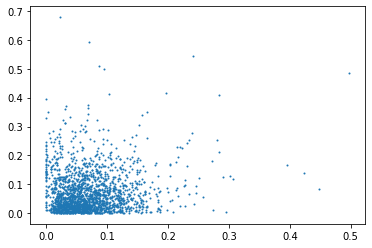

In [73]:
plt.scatter(WFC_ACS.MAD, WFC_ACS.MaxminMin,s=1)

84.674346 -69.0742451
./WFC2_crcleaned/ib6wd1rrq_crclean_wfc2.fits    1712.0    1464.638
./WFC2_crcleaned/ib6wd4kvq_crclean_wfc2.fits    1711.782    1508.233
./WFC2_crcleaned/ib6wd3fdq_crclean_wfc2.fits    1717.383    1506.0
./WFC2_crcleaned/ib6wd5gdq_crclean_wfc2.fits    1716.553    1465.091
./WFC2_crcleaned/ib6wd7hdq_crclean_wfc2.fits    1721.921    1507.576
./WFC2_crcleaned/ib6wd6e9q_crclean_wfc2.fits    1719.631    1462.842
./WFC2_crcleaned/ib6wr8jhq_crclean_wfc2.fits    1729.655    1505.0


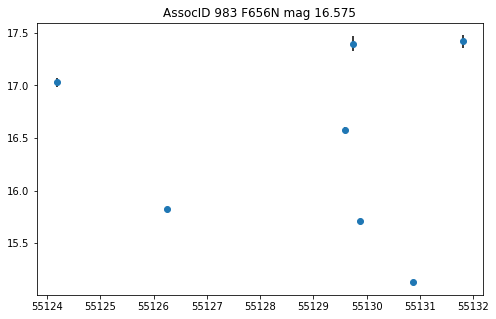

In [74]:
Analyzer.inspect(983, 'F656N')

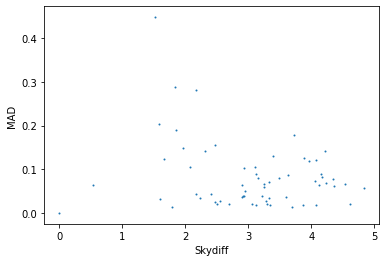

In [75]:
sky_mad[sky_mad.MedSky<40].plot.scatter(x='Skydiff', y='MAD', s=1)

In [76]:
from matplotlib.colors import LogNorm
plt.hist2d(sky_mad['MagminSky'], sky_mad['MAD'], bins=(np.linspace(10,50,50), np.linspace(0,1,100)), norm=LogNorm())
plt.show()


KeyError: 'MagminSky'

In [77]:
b=Analyzer.get_mad_mag_nom()
b= b.join(Analyzer.GetMinMaxvalues(), rsuffix='_minmag')

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [78]:
b.sort_values(by='MAG_minmag')

,,MAG,MAD,Nmeas,MADSigma,MAG_minmag
AssocID,Filter,,,,,
17755.0,F336W,23.850000,0.00000,1,0.000000,0.00000
17266.0,F438W,25.486500,0.00000,1,0.000000,0.00000
15201.0,F656N,19.747000,0.00000,1,0.000000,0.00000
10009.0,F656N,20.090000,0.00000,1,0.000000,0.00000
15710.0,F438W,25.010000,0.00000,1,0.000000,0.00000
...,...,...,...,...,...,...
11427.0,F336W,22.595875,0.22625,16,6.961538,6.05325
10273.0,F336W,20.849750,1.61150,14,85.946667,6.16300
10034.0,F336W,21.984500,0.37350,18,14.365385,6.23100


In [79]:
b[b.index.get_level_values(1)=='F656N'].sort_values(by='MAG_minmag')#.plot.scatter(x='MAD', y='MAG_minmag',s=1)

,,MAG,MAD,Nmeas,MADSigma,MAG_minmag
AssocID,Filter,,,,,
11908.0,F656N,20.600000,0.000000,1,0.000000,0.00000
9192.0,F656N,18.429000,0.000000,1,0.000000,0.00000
10524.0,F656N,21.687000,0.000000,1,NaN,0.00000
14592.0,F656N,19.143500,0.000000,1,0.000000,0.00000
17543.0,F656N,19.590000,0.000000,1,0.000000,0.00000
...,...,...,...,...,...,...
11545.0,F656N,16.392500,0.077250,7,2.874419,3.20500
8201.0,F656N,17.458125,0.496750,8,18.570093,3.58625
1261.0,F656N,17.273250,0.414125,8,17.908108,3.91950


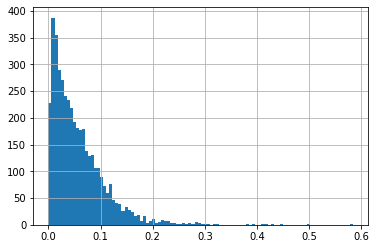

In [81]:
c=pd.merge(b,all_stars[['RA','Dec']], left_on='AssocID', right_index=True)
c=c[c.index.get_level_values(1)=='F656N'].sort_values(by='MAG_minmag')
c[c.MAG<25].MAD.hist(bins=100)

In [ ]:
Analyzer.inspect(890, 'F656N')

In [292]:
bg_1 = 101124.8
bg_2 = 103505.7

In [293]:
st1 = 163183.12
st2 = 160074.52

In [295]:
bg_2/bg_1

1.0235441751182697

In [301]:
-2.5*np.log10((st2-bg_2))

-11.881442799121062

In [303]:
-2.5*np.log10((st1-bg_1))

-11.982000036217155

In [82]:
df = pd.DataFrame({'X' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['i_1'], 'Y' : all_stars[all_stars['eha_2'] < 0.15]['v_1'] - all_stars[all_stars['eha_2'] < 0.15]['ha_1']})  #we build a dataframe from the data
_, bins=pd.qcut(df.X,70, retbins=True)
data_cut = pd.cut(df.X,bins)           #we cut the data following the bins
grp = df.groupby(by = data_cut)        #we group the data by the cut

ret = grp.aggregate(np.median)         #we produce an aggregate representation (median) of each bin
#plt.scatter(df.X,df.Y,color='k',alpha=.2,s=2)
#plt.plot(ret.X,ret.Y,'r--',lw=4,alpha=.8)

fit = np.polyfit(ret.X,ret.Y, 4)
def running_median(VI_color):
    return np.poly1d(fit)(VI_color)

df= Analyzer.merge_color_maxha('F555W','F814W')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:273: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


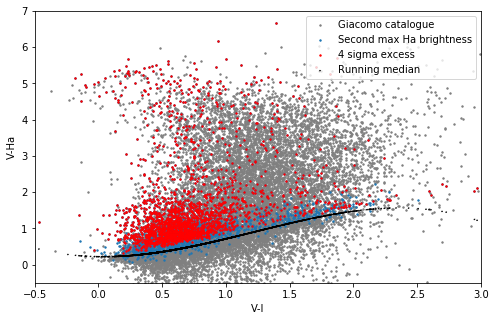

2021


In [83]:
plt.figure(figsize=(8,5))
plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
five_sigma_excess = ((df.F555W-df.SecondMaxHa) - running_median(df.F555W-df.F814W))/np.sqrt((df.eColor**2+df.HaErr**2))>=4
#plt.scatter((Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F814W']),(Analyzer.MedMag.unstack()['F555W'] - Analyzer.MedMag.unstack()['F656N']), s=1, label='Median colors')
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1']-all_stars['ha_1'], color='grey', s=2, label='Giacomo catalogue')
plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')

plt.xlabel('V-I')
plt.ylabel('V-Ha')
plt.legend(loc='best')
plt.show()
print(five_sigma_excess.sum())
ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

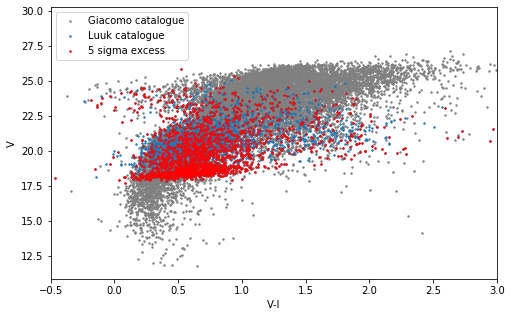

In [84]:
plt.figure(figsize=(8,5))
#plt.ylim(-0.5,7)
plt.xlim(-0.5,3)
plt.scatter(all_stars['v_1']-all_stars['i_1'], all_stars['v_1'], color='grey', s=2, label='Giacomo catalogue')
#plt.scatter(df.F555W-df.F814W, df.F555W-df.SecondMaxHa, s=2, label='Second max Ha brightness')
#plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W-df.SecondMaxHa)[five_sigma_excess], s=2, c='red', label='4 sigma excess')
#plt.scatter(df.F555W-df.F814W,running_median(df.F555W-df.F814W), color='black', s=1, ls='dotted', label='Running median')
plt.scatter((df.F555W-df.F814W), (df.F555W), s=2, label='Luuk catalogue')
plt.scatter((df.F555W-df.F814W)[five_sigma_excess], (df.F555W)[five_sigma_excess], s=2, c='red', label='5 sigma excess')


plt.xlabel('V-I')
plt.ylabel('V')
plt.legend(loc='best')
plt.show()

#print(five_sigma_excess.sum())
#ha_excess_stars = five_sigma_excess.index[five_sigma_excess].values

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


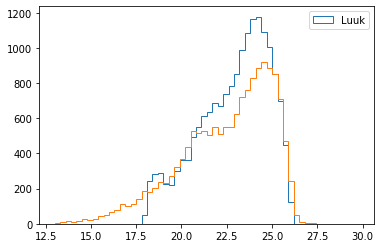

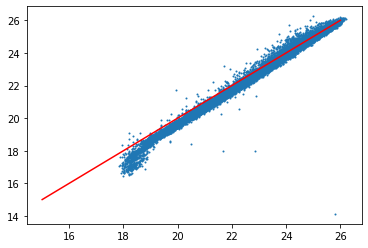

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


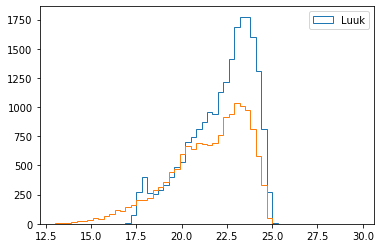

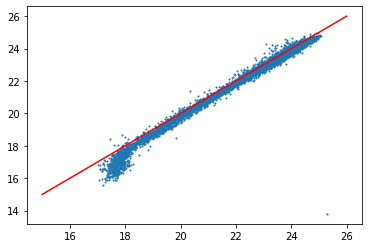

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


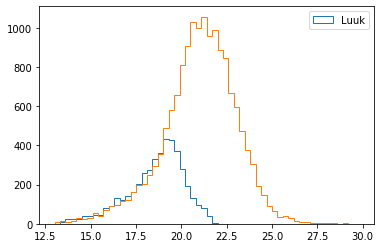

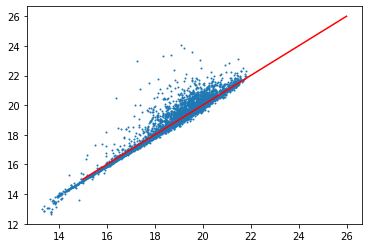

In [85]:
F555mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F555W'].droplevel(1)
merged = pd.merge(F555mags,all_stars['v_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['v_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['v_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()



F814Wmags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F814W'].droplevel(1)
merged = pd.merge(F814Wmags,all_stars['i_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['i_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['i_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()
F656mags = Analyzer.GetMedMags()[Analyzer.GetMedMags().index.get_level_values(1)=='F656N'].droplevel(1)
merged = pd.merge(F656mags,all_stars['ha_1'], left_index=True, right_index=True, how='outer')
plt.hist(merged['MAG'], histtype='step', normed=False, label='Luuk', bins=np.arange(13,30,0.3))
plt.hist(merged['ha_1'], histtype='step', normed=False, bins=np.arange(13,30,0.3))
plt.legend()
plt.show()
plt.scatter(merged.dropna()['MAG'], merged.dropna()['ha_1'], s=1)
plt.plot([15,26],[15,26], color='red')
plt.show()

In [86]:
data = Analyzer.get_max_ha().dropna()
MaxMin = data.MinHa - data.MaxHa
MaxMin2 = data.SecondMinHa - data.MaxHa
Max2Min = data.MinHa - data.SecondMaxHa
Max2Min2 = data.SecondMinHa - data.SecondMaxHa

2021


/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


2299
2021
2299


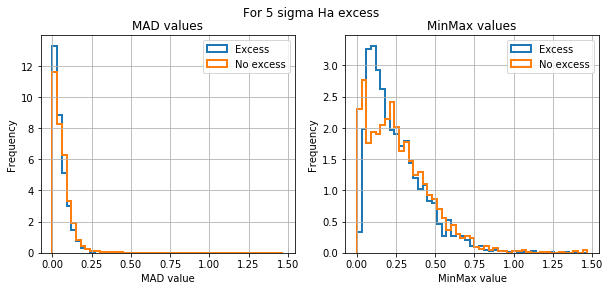

In [87]:
plt.figure(figsize=(10,4))
mads = Analyzer.GetMADvalues()
mads=mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[ha_excess_stars]
print(len(excess_mad))

not_pms = np.setdiff1d(mads.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_mad = mads.loc[not_pms]

print(len(not_excess_mad))
plt.subplot(121)
excess_mad.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_mad.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='No excess', normed=True, linewidth=2)
plt.title('MAD values')

plt.suptitle('For 5 sigma Ha excess')
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

plt.subplot(122)
plt.title('MinMax values')
minmax = Analyzer.GetMinMaxvalues()
minmax=minmax[minmax.index.get_level_values(1)=='F656N']
excess_minmax = minmax.loc[ha_excess_stars]
print(len(excess_mad))
not_pms = np.setdiff1d(minmax.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_minmax = minmax.loc[not_pms]
print(len(not_excess_mad))

excess_minmax.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_minmax.hist(bins=np.arange(0,1.5,0.03), histtype='step', label='No excess', normed=True, linewidth=2)
plt.legend()
plt.xlabel('MinMax value')
plt.ylabel('Frequency')
plt.savefig('5sigma_excess_mad_minmax.png', dpi=500)
plt.show()

2021
2299
2021
2299


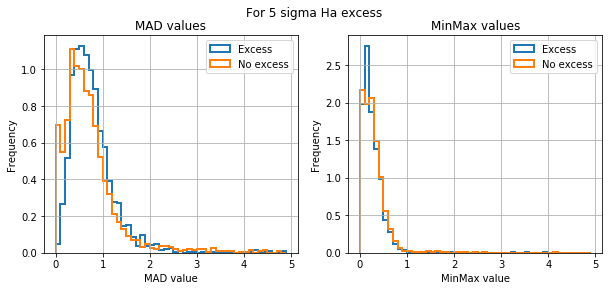

In [88]:
plt.figure(figsize=(10,4))
mads = Analyzer.GetMADvalues()
mads = pd.merge(mads, phot_df.groupby(['AssocID', 'Filter'])['MERR'].median(), left_index=True, right_index=True)
mads = mads.MAG/mads.MERR
mads=mads[mads.index.get_level_values(1)=='F656N']
excess_mad = mads.loc[ha_excess_stars]
print(len(excess_mad))

not_pms = np.setdiff1d(mads.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_mad = mads.loc[not_pms]

print(len(not_excess_mad))
plt.subplot(121)
excess_mad.hist(bins=np.arange(0,5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_mad.hist(bins=np.arange(0,5,0.1), histtype='step', label='No excess', normed=True, linewidth=2)
plt.title('MAD values')

plt.suptitle('For 5 sigma Ha excess')
plt.legend()
plt.xlabel('MAD value')
plt.ylabel('Frequency')

plt.subplot(122)
plt.title('MinMax values')
minmax = Analyzer.GetMinMaxvalues()
minmax = pd.merge(minmax, phot_df.groupby(['AssocID', 'Filter'])['MERR'].median(), left_index=True, right_index=True)
minmax = minmax.MAG#/minmax.MERR


minmax=minmax[minmax.index.get_level_values(1)=='F656N']
excess_minmax = minmax.loc[ha_excess_stars]
print(len(excess_mad))
not_pms = np.setdiff1d(minmax.reset_index().AssocID, pms_stars.index.values)
not_pms = np.setdiff1d(not_pms, ha_excess_stars)
not_excess_minmax = minmax.loc[not_pms]
print(len(not_excess_mad))

excess_minmax.hist(bins=np.arange(0,5,0.1), histtype='step', label='Excess', normed=True, linewidth=2)
not_excess_minmax.hist(bins=np.arange(0,5,0.1), histtype='step', label='No excess', normed=True, linewidth=2)
plt.legend()
plt.xlabel('MinMax value')
plt.ylabel('Frequency')
plt.savefig('5sigma_excess_mad_minmax.png', dpi=500)
plt.show()

In [89]:
all_stars[(all_stars['eha_2']>0.4)&(all_stars['eha_2']<0.8)].sort_values(by='ha_1')

,x,y,RA,Dec,u_1,eu_2,b_1,eb_2,v_1,ev_2,i_1,ei_2,ha_1,eha_2
ID,,,,,,,,,,,,,,
65,3929.362,1956.681,84.649650,-69.084343,13.334,0.177,14.566,-99.000,14.373,0.370,14.016,1.301,13.982,0.665
89,3024.050,2587.028,84.677128,-69.077518,13.515,0.327,14.823,0.324,14.703,0.150,14.437,0.577,14.391,0.525
81,3955.122,3845.331,84.648906,-69.063881,13.163,0.217,14.620,1.231,14.616,0.303,14.534,-99.000,14.408,0.461
91,3094.671,3061.830,84.674989,-69.072373,13.444,0.324,14.801,0.728,14.715,0.407,14.535,-99.000,14.444,0.415
109,4155.872,3001.118,84.642800,-69.073025,13.616,0.291,14.905,-99.000,14.811,0.213,14.395,0.714,14.455,0.637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17693,2684.068,2427.627,84.687442,-69.079245,26.560,0.116,25.792,0.052,25.045,0.037,23.768,0.022,28.397,0.529
21105,2459.567,2598.562,84.694253,-69.077393,-99.000,-99.000,26.996,0.132,25.837,0.047,23.896,0.021,28.843,0.570
8451,4037.173,4061.985,84.646423,-69.061533,23.697,0.075,23.485,0.029,22.830,0.035,21.596,0.023,28.922,0.406


In [90]:
df['MinMax'] = df['MinHa'] - df['MaxHa']

In [91]:
b=pd.merge(df, all_stars[['ha_1', 'eha_2']], left_on='AssocID', right_index=True).sort_values('eha_2')
b[b.ha_1<17.5].sort_values(by='MinMax').tail(20)

,Color,eColor,MaxHa,SecondMaxHa,MinHa,SecondMinHa,MedHa,HaErr,F555W,F814W,MinMax,ha_1,eha_2
AssocID,,,,,,,,,,,,,
830.0,0.599500,0.005000,17.22550,17.27700,17.51200,17.42125,17.304625,0.0180,18.441500,17.842000,0.28650,17.240,0.011
818.0,0.544750,0.005831,17.36675,17.36975,17.65500,17.54200,17.470750,0.0955,18.489250,17.944500,0.28825,17.393,0.063
773.0,0.664750,0.005000,17.12400,17.26875,17.43025,17.41950,17.392750,0.0305,18.458125,17.793375,0.30625,17.246,0.011
605.0,0.522500,0.005385,16.75750,16.85950,17.06975,17.02950,17.013500,0.0200,18.459500,17.937000,0.31225,16.862,0.014
712.0,0.431500,0.003606,17.12850,17.18250,17.45000,17.43000,17.250000,0.0100,18.306500,17.875000,0.32150,17.074,0.005
1145.0,0.573500,0.007810,17.18950,17.31150,17.51700,17.49325,17.455500,0.0950,18.688750,18.115250,0.32750,17.471,0.057
785.0,0.160750,0.185662,17.59750,17.72700,17.93375,17.84975,17.817000,0.1840,18.349250,18.188500,0.33625,17.415,0.045
672.0,0.622625,0.009487,16.93900,17.05400,17.27700,17.14175,17.112875,0.0680,18.555000,17.932375,0.33800,17.048,0.035
1461.0,1.082250,0.005831,17.22950,17.31425,17.57850,17.55800,17.481500,0.0720,19.175250,18.093000,0.34900,17.269,0.041


84.6551954 -69.067981
./WFC2_crcleaned/ib6wd1rrq_crclean_wfc2.fits    1248.349    791.183
./WFC2_crcleaned/ib6wd4kvq_crclean_wfc2.fits    1249.844    835.007
./WFC2_crcleaned/ib6wd2btq_crclean_wfc2.fits    1242.133    791.887
./WFC2_crcleaned/ib6wd3fdq_crclean_wfc2.fits    1255.107    833.26
./WFC2_crcleaned/ib6wd5gdq_crclean_wfc2.fits    1252.452    791.965
./WFC2_crcleaned/ib6wd7hdq_crclean_wfc2.fits    1260.195    834.389
./WFC2_crcleaned/ib6wd6e9q_crclean_wfc2.fits    1258.304    789.375
./WFC2_crcleaned/ib6wr8jhq_crclean_wfc2.fits    1265.468    831.831


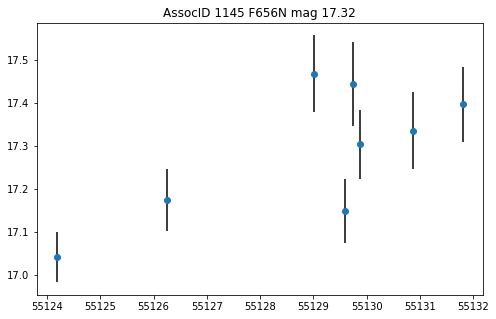

In [192]:
Analyzer.inspect(1145, 'F656N')

(0, 1)

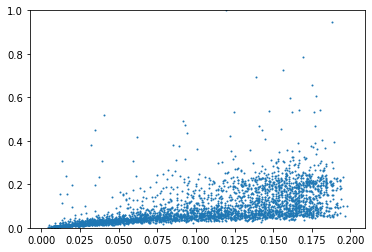

In [142]:
plt.scatter(b['HaErr'], b['eha_2'], s=1)
plt.ylim(0,1)

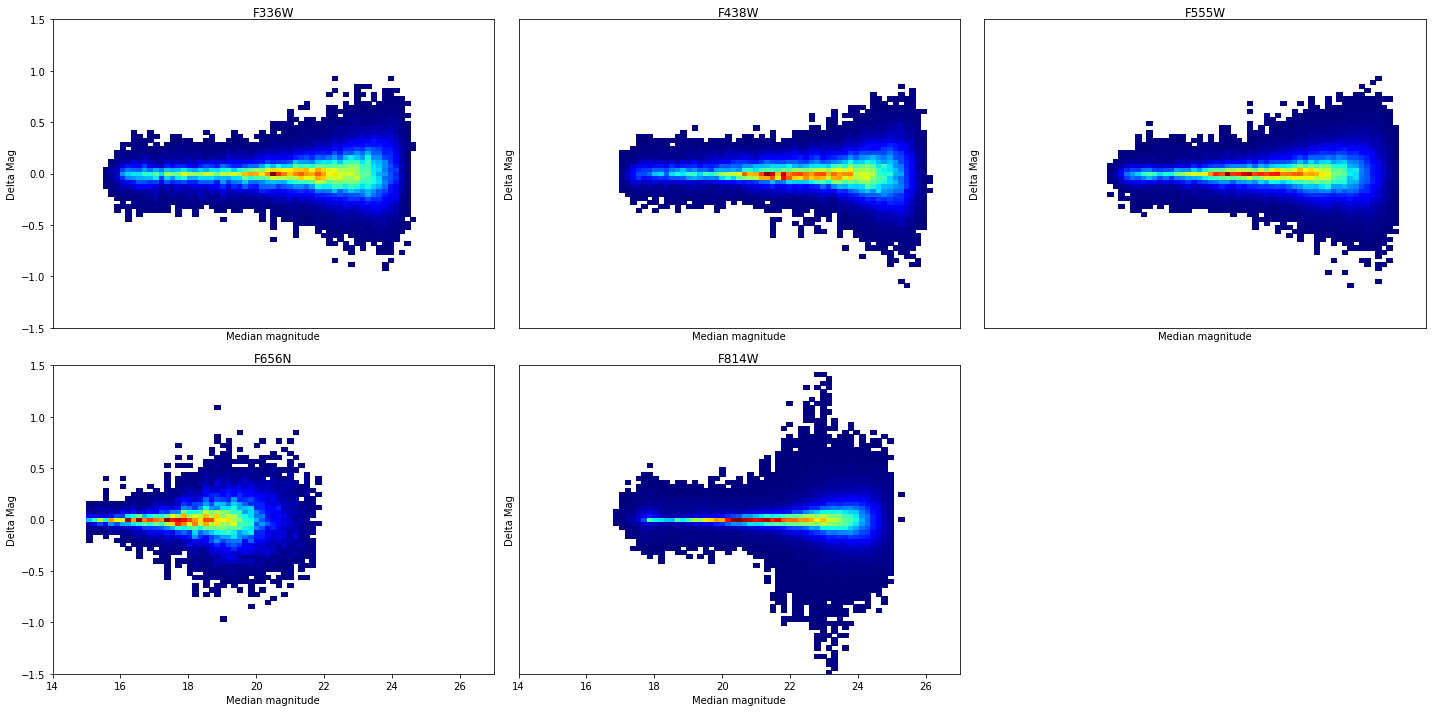

In [261]:
Analyzer.DrawTrumpets()

In [183]:
sex_phot_df = pd.read_pickle('../SExtractor/Analysis/MZPCleanedPhot_whitelightregrid.pickle')

In [178]:
#sex_phot_df = sex_phot_df.groupby(['AssocID', 'Filter'])['MAG_APER2'].median()

In [184]:
sex_iraf = pd.DataFrame(sex_phot_df['MAG_APER2']).join(phot_df.MAG, how='inner')

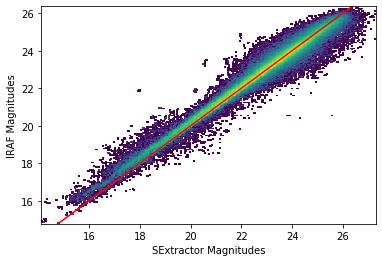

In [185]:
from matplotlib.colors import LogNorm
plt.hist2d(sex_iraf.MAG_APER2, sex_iraf.MAG,bins=250, norm=LogNorm())
plt.plot([14,28],[14,28], color='red')
plt.xlabel('SExtractor Magnitudes')
plt.ylabel('IRAF Magnitudes')
plt.show()

In [266]:
pd.DataFrame(Analyzer.GetMADvalues())

MAG
AssocID Filter          
16.0    F656N   0.010750
18.0    F656N   0.024875
19.0    F656N   0.018875
20.0    F656N   0.024000
21.0    F656N   0.014125
...                  ...
22286.0 F555W   0.053750
        F656N   0.053375
        F814W   0.008875
22291.0 F438W   0.115500
        F814W   0.069500

[68867 rows x 1 columns]

In [267]:
a=pd.merge(Analyzer.GetMADvalues(), all_stars[['RA', 'Dec']], left_on='AssocID', right_index=True)

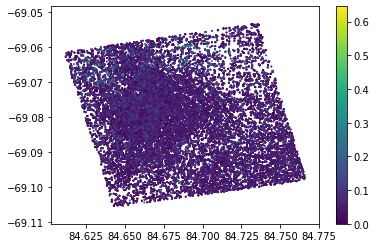

In [268]:
plt.scatter(a.RA, a.Dec, c=a.MAG, s=1)
plt.colorbar()

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


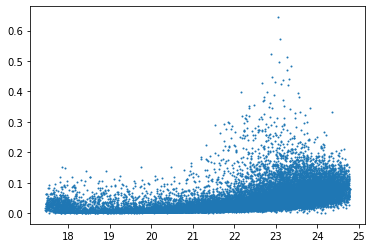

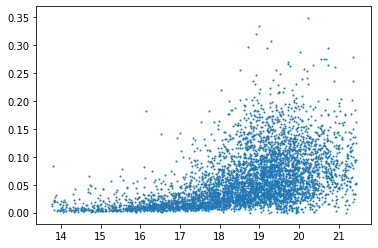

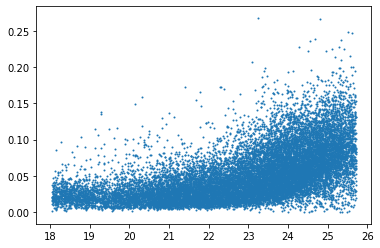

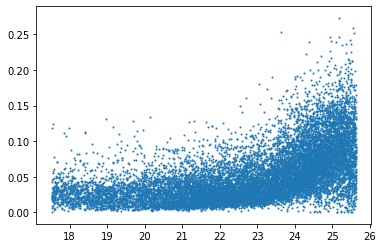

In [269]:
a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F814W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F656N']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F555W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

a=Analyzer.median_mad_sigma()
a=a[a.index.get_level_values(1)=='F438W']
plt.scatter(a.MAG, (a.MAD), s=1)
plt.show()

In [96]:
xybin_phot = phot_df[['MAG', 'XCENTER', 'YCENTER', 'MZPCorr']]


In [105]:
xybin_phot['XBIN'] = pd.cut(xybin_phot['XCENTER'], bins=400)
xybin_phot['YBIN'] = pd.cut(xybin_phot['YCENTER'], bins=400)

xybin_phot['XBIN'] = xybin_phot['XBIN'].apply(lambda x: x.mid)
xybin_phot['YBIN'] = xybin_phot['YBIN'].apply(lambda x: x.mid)

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [106]:
xybin_phot = xybin_phot[xybin_phot.index.get_level_values(1)=='F814W']

In [107]:
maxmin = xybin_phot.groupby(['XBIN', 'YBIN'])['MZPCorr'].median()# - xybin_phot.groupby(['XBIN', 'YBIN'])['MAG'].min()

In [108]:
x, y, deltamag = maxmin.dropna().index.get_level_values(0), maxmin.dropna().index.get_level_values(1), maxmin.dropna().values

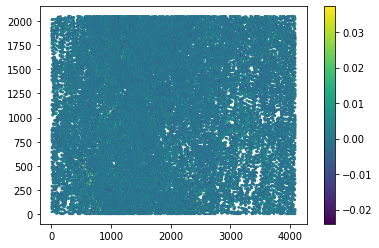

In [110]:
plt.scatter(x, y, c=deltamag, s=2)
plt.colorbar()

In [95]:
phot_df.MZPCorr

AssocID  Filter  T_Start     
16.0     F656N   55124.185716    0.00000
                 55126.249026    0.00000
                 55129.006966    0.00575
                 55129.594107    0.00000
                 55129.735461    0.00000
                                  ...   
22177.0  F814W   55129.658123    0.00525
                 55129.667313    0.00175
                 55129.930148   -0.00125
                 55130.936804   -0.00250
                 55131.874929    0.00750
Name: MZPCorr, Length: 730035, dtype: float64

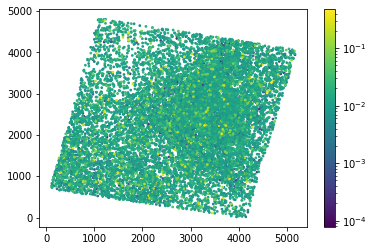

In [121]:
from matplotlib.colors import LogNorm
plt.scatter(all_stars.x, all_stars.y, c=all_stars.eha_2/all_stars.ha_1, s=3, norm=LogNorm())
plt.colorbar()

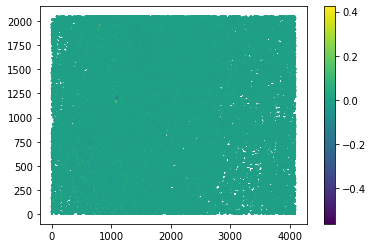

In [190]:
plt.scatter(phot_df.XCENTER, phot_df.YCENTER, c=phot_df.MZPCorr,s=1)
plt.colorbar()